In [18]:
!git clone https://github.com/Heity94/AugmentedHierarchicalShrinkage.git

Cloning into 'AugmentedHierarchicalShrinkage'...
remote: Enumerating objects: 903, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 903 (delta 72), reused 70 (delta 70), pack-reused 822
Receiving objects: 100% (903/903), 124.13 MiB | 36.54 MiB/s, done.
Resolving deltas: 100% (500/500), done.


In [19]:
%cd AugmentedHierarchicalShrinkage

/content/AugmentedHierarchicalShrinkage/AugmentedHierarchicalShrinkage


In [20]:
!pip install shap

In [21]:
!pip install -e .

Obtaining file:///content/AugmentedHierarchicalShrinkage/AugmentedHierarchicalShrinkage
  Preparing metadata (setup.py) ... done
  Attempting uninstall: AugmentedHierarchicalShrinkage
    Found existing installation: AugmentedHierarchicalShrinkage 1
    Uninstalling AugmentedHierarchicalShrinkage-1:
      Successfully uninstalled AugmentedHierarchicalShrinkage-1
  Running setup.py develop for AugmentedHierarchicalShrinkage


#### With K and Max Feature - Custom RF

In [32]:
import numpy as np
import numbers
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from shap import TreeExplainer, summary_plot
import matplotlib.pyplot as plt
from TreeModelsFromScratch.RandomForest import RandomForest

def simulate_data_strobl(n=120, # number of rows in data
                         M=100, # number of features
                         relevance=0.15, # signal strength (0 for NULL)
                         seed=None):
    """Simulate Strobl-like dataset with corrected dimensions."""

    if isinstance(seed, numbers.Integral) or (seed is None):
        random_state = np.random.RandomState(seed)
    elif isinstance(seed, np.random.RandomState):
        random_state = seed

    # Assuming you want different types of features but all flattened to a 1D array per type
    x1 = random_state.standard_normal(size=n)
    x2 = random_state.randint(1, 3, size=n)
    x3 = random_state.randint(1, 5, size=n)
    x4 = random_state.randint(1, 11, size=n)
    x5 = random_state.randint(1, 21, size=n)
    # Stack them to get a shape of (n, 5) - assuming you want each x as a feature
    X = np.column_stack([x1, x2, x3, x4, x5])

    # Adjust the target generation as per your logic
    # Example assuming relevance impacts the probability linearly for simplicity
    y = random_state.binomial(n=1, p=0.5 + relevance * (x2 - 1) / 2.0)

    return X, y

# Example usage
n = 300  # Number of samples
M = 5  # Adjusted to reflect the number of feature types you're generating
relevance_power = 0.5
random_seed = 42
X, y = simulate_data_strobl(n=n, M=M, relevance=relevance_power, seed=random_seed)

# Now you can split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)



# Parameters to explore
k_values = [1, 2, 4, 6, 8, 10, 15]
max_features_values = [0.2, 0.4, 0.6, 0.8]
from sklearn.metrics import roc_auc_score

def calculate_auc_roc(y_true, y_scores):
    """Calculate the AUC-ROC score given true labels and the scores for the positive class."""
    return roc_auc_score(y_true, y_scores)

def find_best_parameters(model_config, X_train, y_train, X_test, y_test, k_values, max_features_values):
    """Find the best k and max_features for a given RandomForest model configuration."""
    best_score = -1  # Initialize with -1 because AUC-ROC cannot be negative
    best_params = {'k': None, 'max_features': None, 'model_config': model_config}

    for k in k_values:
        for max_features in max_features_values:
            model = RandomForest(treetype="classification",
                                 HShrinkage=model_config['HShrinkage'],
                                 HS_smSHAP=model_config['HS_smSHAP'],
                                 n_trees=25,
                                 k=k,
                                 n_feature=max_features)
            model.fit(X_train, y_train)

            # Assuming the model has a predict_proba method
            y_scores = model.predict_proba(X_test)[:, 1]

            # Calculate AUC-ROC
            score = calculate_auc_roc(y_test, y_scores)

            # Update best parameters if the current score is better
            if score > best_score:
                best_score = score
                best_params['k'] = k
                best_params['max_features'] = max_features

    return best_params, best_score

# Model configurations
model_configs = [
    {'HShrinkage': False, 'HS_smSHAP': False},
    {'HShrinkage': True, 'HS_smSHAP': False},
    {'HShrinkage': True, 'HS_smSHAP': True}
]

# Parameter values to explore
k_values = [1, 2, 4, 6, 8, 10, 15]
max_features_values = [0.2, 0.4, 0.6, 0.8]

# Iterate over each model configuration
results = []
for config in model_configs:
    best_params, best_score = find_best_parameters(config, X_train, y_train, X_test, y_test, k_values, max_features_values)
    results.append((best_params, best_score))

# Output the best parameters and their corresponding scores for each model configuration
for result in results:
    print(f"Best parameters for model configuration {result[0]['model_config']}: k = {result[0]['k']}, max_features = {result[0]['max_features']} with AUC-ROC score: {result[1]}")


Best parameters for model configuration {'HShrinkage': False, 'HS_smSHAP': False}: k = 15, max_features = 0.8 with AUC-ROC score: 0.5646008403361344
Best parameters for model configuration {'HShrinkage': True, 'HS_smSHAP': False}: k = 6, max_features = 0.4 with AUC-ROC score: 0.5945378151260504
Best parameters for model configuration {'HShrinkage': True, 'HS_smSHAP': True}: k = 10, max_features = 0.6 with AUC-ROC score: 0.5787815126050421


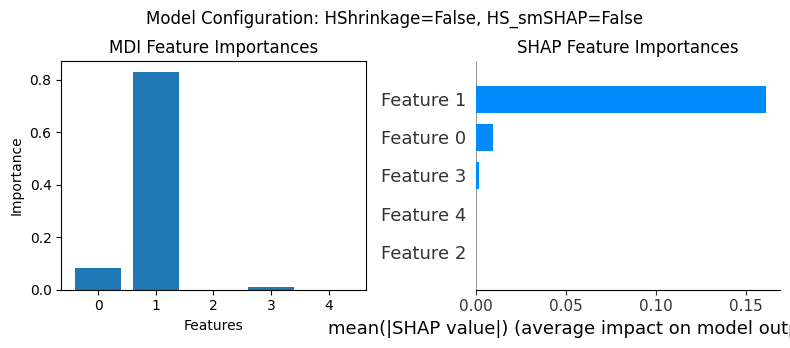

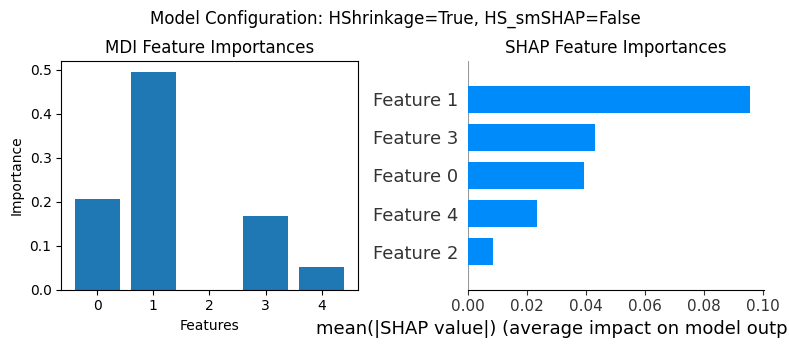

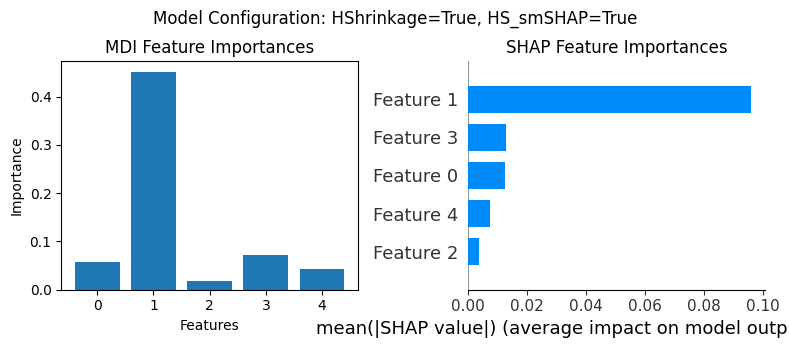

In [35]:
import matplotlib.pyplot as plt
import shap  # Assuming SHAP is installed

# Iterate over the results to plot MDI and SHAP importances for each best model
for result in results:
    best_k = result[0]['k']
    best_max_features = result[0]['max_features']
    model_config = result[0]['model_config']

    # Fit the model with the best parameters for this configuration
    model = RandomForest(treetype="classification", HShrinkage=model_config['HShrinkage'],
                         HS_smSHAP=model_config['HS_smSHAP'], n_trees=25, k=best_k,
                         n_feature=best_max_features)
    model.fit(X_train, y_train)

    # Compute MDI Feature Importances for the model
    mdi_importances = model.feature_importances_

    # Plotting the MDI feature importances
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.title('\nMDI Feature Importances')
    plt.bar(range(len(mdi_importances)), mdi_importances)
    plt.xlabel('Features')
    plt.ylabel('Importance')

    # Prepare the model for SHAP analysis
    model_for_shap = model.export_forest_for_SHAP()  # This assumes your RandomForest model has this method

    # Compute SHAP values
    explainer = shap.TreeExplainer(model_for_shap)
    shap_values = explainer.shap_values(X_test)

    # Plotting SHAP summary plot for the model
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=[f'Feature {i}' for i in range(X_test.shape[1])], max_display=20, show=False)
    plt.title('\nSHAP Feature Importances')

    plt.suptitle(f'Model Configuration: HShrinkage={model_config["HShrinkage"]}, HS_smSHAP={model_config["HS_smSHAP"]}')
    plt.show()


### With Depth and K

In [39]:
%cd ..

/content


In [ ]:
%cd ..

In [40]:
!git clone https://github.com/atikul-islam-sajib/TreeBasedModel.git

Cloning into 'TreeBasedModel'...
remote: Enumerating objects: 915, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 915 (delta 3), reused 8 (delta 3), pack-reused 907
Receiving objects: 100% (915/915), 124.15 MiB | 36.21 MiB/s, done.
Resolving deltas: 100% (505/505), done.


In [41]:
%cd /content/TreeBasedModel

/content/TreeBasedModel


In [42]:
import numpy as np
import numbers
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from shap import TreeExplainer, summary_plot
import matplotlib.pyplot as plt
from TreeModelsFromScratch.RandomForest import RandomForest

def simulate_data_strobl(n=120, # number of rows in data
                         M=100, # number of features
                         relevance=0.15, # signal strength (0 for NULL)
                         seed=None):
    """Simulate Strobl-like dataset with corrected dimensions."""

    if isinstance(seed, numbers.Integral) or (seed is None):
        random_state = np.random.RandomState(seed)
    elif isinstance(seed, np.random.RandomState):
        random_state = seed

    # Assuming you want different types of features but all flattened to a 1D array per type
    x1 = random_state.standard_normal(size=n)
    x2 = random_state.randint(1, 3, size=n)
    x3 = random_state.randint(1, 5, size=n)
    x4 = random_state.randint(1, 11, size=n)
    x5 = random_state.randint(1, 21, size=n)
    # Stack them to get a shape of (n, 5) - assuming you want each x as a feature
    X = np.column_stack([x1, x2, x3, x4, x5])

    # Adjust the target generation as per your logic
    # Example assuming relevance impacts the probability linearly for simplicity
    y = random_state.binomial(n=1, p=0.5 + relevance * (x2 - 1) / 2.0)

    return X, y

# Example usage
n = 300  # Number of samples
M = 5  # Adjusted to reflect the number of feature types you're generating
relevance_power = 0.5
random_seed = 42
X, y = simulate_data_strobl(n=n, M=M, relevance=relevance_power, seed=random_seed)

# Now you can split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)



# Parameters to explore
k_values = [1, 2, 4, 6, 8, 10, 15]
max_features_values = [0.2, 0.4, 0.6, 0.8]
from sklearn.metrics import roc_auc_score

def calculate_auc_roc(y_true, y_scores):
    """Calculate the AUC-ROC score given true labels and the scores for the positive class."""
    return roc_auc_score(y_true, y_scores)

def find_best_parameters(model_config, X_train, y_train, X_test, y_test, k_values, max_features_values):
    """Find the best k and max_features for a given RandomForest model configuration."""
    best_score = -1  # Initialize with -1 because AUC-ROC cannot be negative
    best_params = {'k': None, 'max_features': None, 'model_config': model_config}

    for k in k_values:
        for max_features in max_features_values:
            model = RandomForest(treetype="classification",
                                 HShrinkage=model_config['HShrinkage'],
                                 HS_smSHAP=model_config['HS_smSHAP'],
                                 n_trees=25,
                                 k=k,
                                 n_feature=max_features)
            model.fit(X_train, y_train)

            # Assuming the model has a predict_proba method
            y_scores = model.predict_proba(X_test)[:, 1]

            # Calculate AUC-ROC
            score = calculate_auc_roc(y_test, y_scores)

            # Update best parameters if the current score is better
            if score > best_score:
                best_score = score
                best_params['k'] = k
                best_params['max_features'] = max_features

    return best_params, best_score

# Model configurations
model_configs = [
    {'HShrinkage': False, 'HS_smSHAP': False},
    {'HShrinkage': True, 'HS_smSHAP': False},
    {'HShrinkage': True, 'HS_smSHAP': True}
]

# Parameter values to explore
k_values = [1, 2, 4, 6, 8, 10, 15]
max_features_values = [0.2, 0.4, 0.6, 0.8]

# Iterate over each model configuration
results = []
for config in model_configs:
    best_params, best_score = find_best_parameters(config, X_train, y_train, X_test, y_test, k_values, max_features_values)
    results.append((best_params, best_score))

# Output the best parameters and their corresponding scores for each model configuration
for result in results:
    print(f"Best parameters for model configuration {result[0]['model_config']}: k = {result[0]['k']}, max_features = {result[0]['max_features']} with AUC-ROC score: {result[1]}")

Best parameters for model configuration {'HShrinkage': False, 'HS_smSHAP': False}: k = 10, max_features = 0.2 with AUC-ROC score: 0.5798319327731093
Best parameters for model configuration {'HShrinkage': True, 'HS_smSHAP': False}: k = 8, max_features = 0.2 with AUC-ROC score: 0.5766806722689075
Best parameters for model configuration {'HShrinkage': True, 'HS_smSHAP': True}: k = 8, max_features = 0.4 with AUC-ROC score: 0.5680147058823529


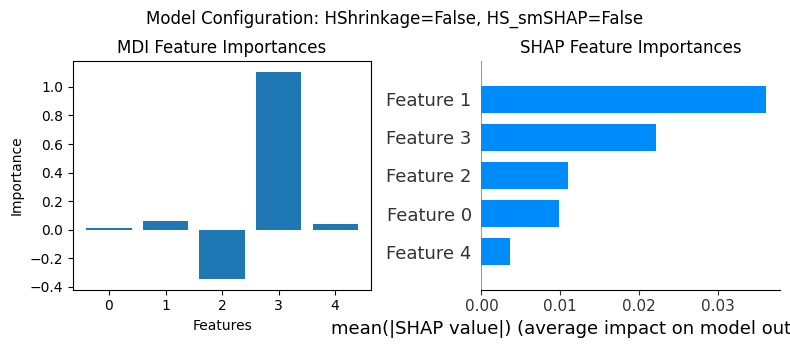

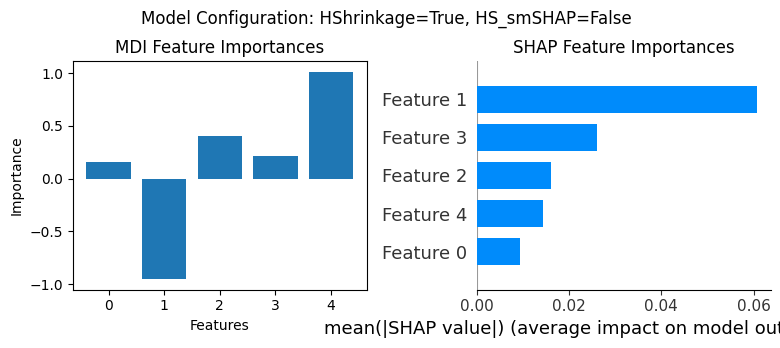

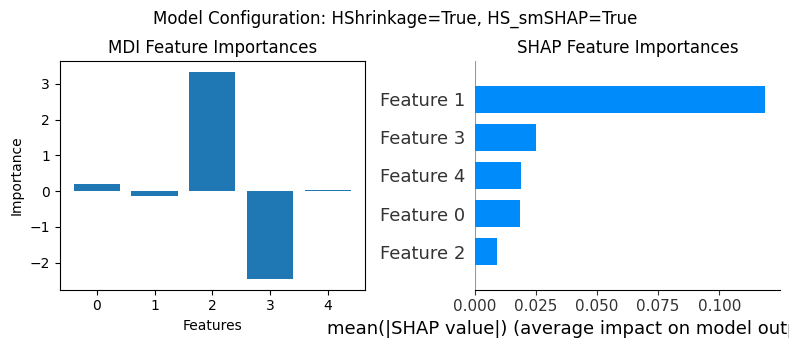

In [43]:
import matplotlib.pyplot as plt
import shap  # Assuming SHAP is installed

# Iterate over the results to plot MDI and SHAP importances for each best model
for result in results:
    best_k = result[0]['k']
    best_max_features = result[0]['max_features']
    model_config = result[0]['model_config']

    # Fit the model with the best parameters for this configuration
    model = RandomForest(treetype="classification", HShrinkage=model_config['HShrinkage'],
                         HS_smSHAP=model_config['HS_smSHAP'], n_trees=25, k=best_k,
                         n_feature=best_max_features)
    model.fit(X_train, y_train)

    # Compute MDI Feature Importances for the model
    mdi_importances = model.feature_importances_

    # Plotting the MDI feature importances
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.title('\nMDI Feature Importances')
    plt.bar(range(len(mdi_importances)), mdi_importances)
    plt.xlabel('Features')
    plt.ylabel('Importance')

    # Prepare the model for SHAP analysis
    model_for_shap = model.export_forest_for_SHAP()  # This assumes your RandomForest model has this method

    # Compute SHAP values
    explainer = shap.TreeExplainer(model_for_shap)
    shap_values = explainer.shap_values(X_test)

    # Plotting SHAP summary plot for the model
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=[f'Feature {i}' for i in range(X_test.shape[1])], max_display=20, show=False)
    plt.title('\nSHAP Feature Importances')

    plt.suptitle(f'Model Configuration: HShrinkage={model_config["HShrinkage"]}, HS_smSHAP={model_config["HS_smSHAP"]}')
    plt.show()

####Sklearn

Best parameters: {'n_estimators': 1, 'max_features': 0.2} with AUC-ROC score: 0.5803571428571428
Type of shap_values: <class 'numpy.ndarray'>
Shape of X_test: (90, 5)
Shape of shap_values_for_plot: (90, 5, 2)


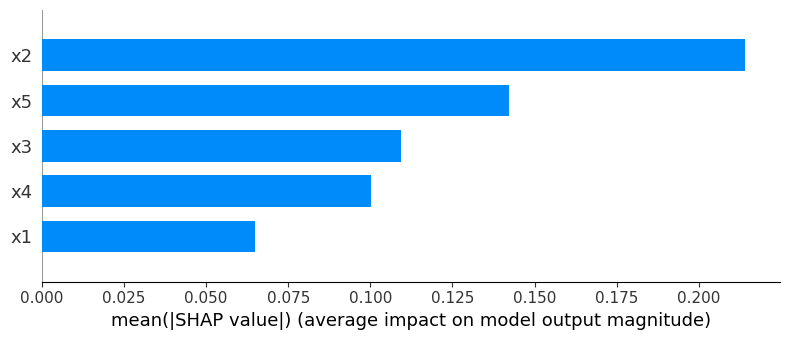

In [57]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
import numbers

# Function to simulate data
def simulate_data_strobl(n=120, M=100, relevance=0.15, seed=None):
    if isinstance(seed, numbers.Integral) or (seed is None):
        random_state = np.random.RandomState(seed)
    elif isinstance(seed, np.random.RandomState):
        random_state = seed

    x1 = random_state.standard_normal(size=n)
    x2 = random_state.randint(1, 3, size=n)
    x3 = random_state.randint(1, 5, size=n)
    x4 = random_state.randint(1, 11, size=n)
    x5 = random_state.randint(1, 21, size=n)
    X = np.column_stack([x1, x2, x3, x4, x5])

    y = random_state.binomial(n=1, p=0.5 + relevance * (x2 - 1) / 2.0)
    return X, y

# AUC-ROC calculation function
def calculate_auc_roc(y_true, y_scores):
    return roc_auc_score(y_true, y_scores)

# Find the best parameters for RandomForest model
def find_best_parameters_sklearn(X_train, y_train, X_test, y_test, k_values, max_features_values):
    best_score = -1
    best_params = {'n_estimators': None, 'max_features': None}

    for n_estimators in k_values:
        for max_features in max_features_values:
            model = RandomForestClassifier(n_estimators=n_estimators,
                                           max_features=max_features,
                                           random_state=42)
            model.fit(X_train, y_train)
            y_scores = model.predict_proba(X_test)[:, 1]
            score = calculate_auc_roc(y_test, y_scores)

            if score > best_score:
                best_score = score
                best_params['n_estimators'] = n_estimators
                best_params['max_features'] = max_features

    return best_params, best_score

# Simulate data
n = 300
M = 5
relevance_power = 0.5
random_seed = 42
X, y = simulate_data_strobl(n=n, M=M, relevance=relevance_power, seed=random_seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

k_values = [1, 2, 4, 6, 8, 10, 15]
max_features_values = [0.2, 0.4, 0.6, 0.8]

# Find best model parameters
best_params, best_score = find_best_parameters_sklearn(X_train, y_train, X_test, y_test, k_values, max_features_values)
print(f"Best parameters: {best_params} with AUC-ROC score: {best_score}")

# Assuming you have already trained your best model and it's named `best_model`
# And you have your `X_test` ready

# Fit the best model
best_model = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                    max_features=best_params['max_features'],
                                    random_state=42)
best_model.fit(X_train, y_train)

# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Directly call shap.summary_plot without additional indexing or manipulation
# If shap_values is a list (common with classifiers), select the element corresponding to the class of interest
# For binary classification with a single estimator, this might be simply shap_values[0] or shap_values[1]
# Assuming binary classification and interest in the positive class (commonly indexed as 1)
shap_values_for_plot = shap_values[1] if isinstance(shap_values, list) else shap_values

# Ensure feature_names is correctly formatted
feature_names = ['x1', 'x2', 'x3', 'x4', 'x5']

# Verify the structure of shap_values
print(f"Type of shap_values: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"Length of shap_values: {len(shap_values)}")
    # If shap_values is a list, use the index for the class of interest
    shap_values_for_plot = shap_values[1]
else:
    # If shap_values is not a list (unexpected for RandomForestClassifier), directly use it
    shap_values_for_plot = shap_values

# Ensure X_test is compatible
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of shap_values_for_plot: {np.array(shap_values_for_plot).shape}")
# Select the SHAP values for the positive class (class 1) for all features
# This adjustment reduces the shap_values_for_plot dimensions from (90, 5, 2) to (90, 5)
shap_values_positive_class = shap_values_for_plot[:, :, 1]

# Now plot the SHAP values for the positive class
shap.summary_plot(shap_values_positive_class, X_test, feature_names=feature_names, plot_type='bar')